In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem, zscore
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
later_dir = '/oak/stanford/groups/trc/data/Ilana/2P/data/later/'

In [3]:
for x in sorted(os.listdir(later_dir)):
    if 'dic' in x:
        print(x)

fly_208_dff_dic.pkl
fly_208_dic.pkl
fly_209_dic.pkl
fly_210_dic.pkl
fly_217_dic.pkl
fly_218_dic.pkl
fly_226_dic.pkl
fly_227_dic.pkl
fly_228_dic.pkl
fly_233_dic.pkl
fly_234_dic.pkl
fly_239_dic.pkl
fly_240_dic.pkl
fly_241_dic.pkl
fly_242_dic.pkl
fly_249_dic.pkl
fly_250_dic.pkl
total_dict.pkl


In [4]:
%%time
total_path = os.path.join(later_dir, 'total_dict.pkl')
if os.path.exists(total_path)==False:
    print("Making total dict")
    total_data_dict = {}

    for x in sorted(os.listdir(later_dir)):
        if 'dic' in x:
            fly_name= x[4:7]
            temp_path = os.path.join(later_dir, x)
            with open(temp_path, 'rb') as file:
                dic = pickle.load(file)
                total_data_dict[fly_name] = dic
    with open(total_path, 'wb') as file:
        pickle.dump(total_data_dict, file)
else:
    print("Loading total dict")
    with open(total_path, 'rb') as file:
        total_data_dict = pickle.load(file)

Loading total dict
CPU times: user 4.9 s, sys: 23 s, total: 27.9 s
Wall time: 27.9 s


In [5]:
print(total_data_dict.keys())
print(total_data_dict['208'].keys())

dict_keys(['208', '209', '210', '217', '218', '226', '227', '228', '233', '234', '239', '240', '241', '242', '249', '250'])
dict_keys(['signals', 'timestamps', 'event_times', 'bins', 'behavior', 'cluster_labels'])


In [6]:
print(np.shape(total_data_dict['208']['timestamps']))

(3384, 49)


In [15]:
%%time
total_behave_struct = {}
shape = 196 #this is hard coded to be the smallest but i gotta figure this shit out better
for x in sorted(os.listdir(later_dir)):
    if 'dic' in x and 'total' not in x:
        fly_name= x[4:7]
        temp_path = os.path.join(later_dir, x)
        with open(temp_path, 'rb') as file:
            struct = pickle.load(file)
            total_behave_struct[fly_name] = struct['behavior'][:shape,:]
            temp = struct['behavior']

CPU times: user 4.94 s, sys: 23.2 s, total: 28.2 s
Wall time: 28.2 s


In [16]:
print(total_behave_struct.keys())
print(np.shape(total_behave_struct['208']))

dict_keys(['208', '209', '210', '217', '218', '226', '227', '228', '233', '234', '239', '240', '241', '242', '249', '250'])
(196, 500)


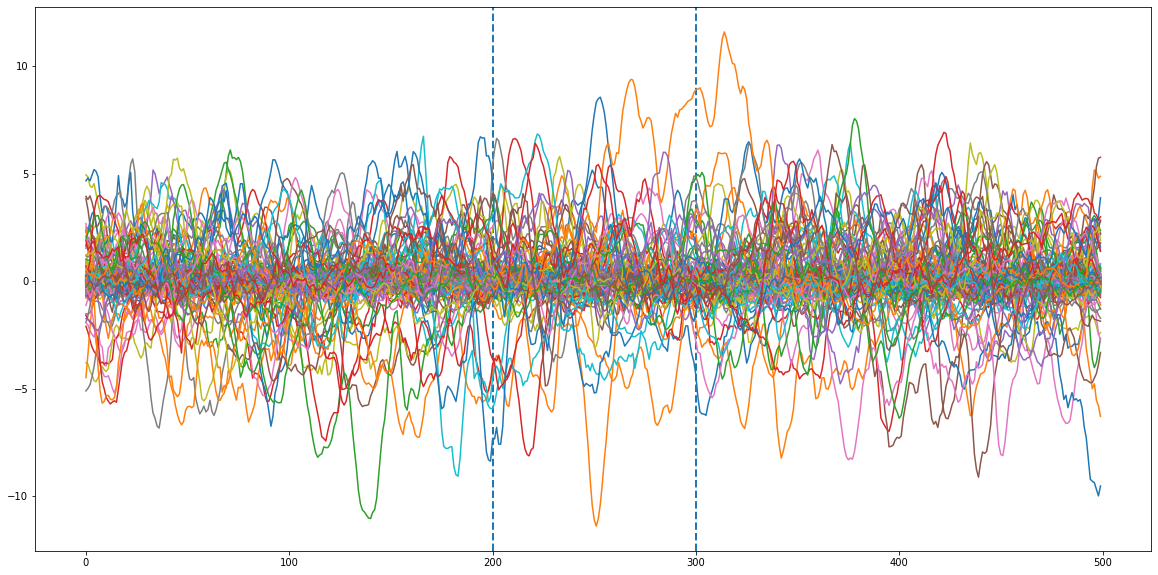

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.axvline(200, linewidth=2, linestyle='--')
ax.axvline(300, linewidth=2, linestyle='--')
# for key in total_behave_struct:
plt.plot(total_behave_struct['217'].T);

In [20]:
def plot_flies(struct):
    fig, ax = plt.subplots(figsize=(20,10))
#     ax.axvline(200, linewidth=2, linestyle='--')
#     ax.axvline(300, linewidth=2, linestyle='--')
    for key in struct:
        f=np.mean(struct[key], axis=0)
    #     print(np.shape(f))
        ax.plot(f.T, label=key)
        ax.legend()
    # # ax.plot(np.mean(total_behave, axis=1).T)

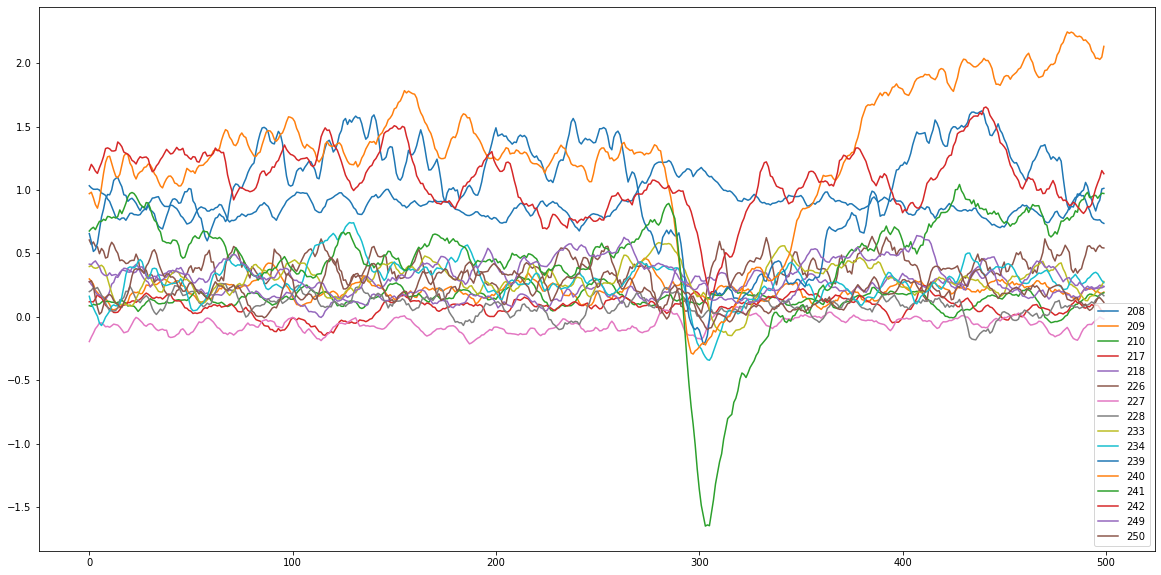

In [21]:
plot_flies(total_behave_struct)

In [ ]:
## For a single fly find:
## 1. How many trials did the flies have a forward velocity below a certain threshold (maybe 0.5mm/sec
## to start but you can fuck with this as needed) and above a certain threshold prior to the stimulus onset?
## 2. How many trials within those categories did the fly respond to the stimulus (this can be any type of 
## response--you decide what that means)?
## 3. What kinds of responses do you see (increased velocity, decreased velocity etc)?
## 4. Is there any sort of correlation between inital velocity and response rate?
## 5. How many trials is the inital foward velocity very low (or other weird things)?
## 6. Can you apply this to multiple flies and do you see similar things from fly to fly?